# **VIDEO VIOLENCE DETECTION**

> **Repository link** : https://github.com/nguemo12/Video-violence-detection.git   
> 
> **Team** : Nguemo Aymard & Ghamacha Asma  
> 
> **Class**: PGE4 

# Project Introduction

> **Project GOAL**:  
>The primary goal of this project is to develop and implement a state-of-the-art deep learning model capable of automatically recognizing violent events in video streams.

>**Approach**
>The project leverages advanced deep learning techniques, specifically convolutional neural networks (CNNs) and recurrent neural networks (RNNs), to analyze both spatial and temporal aspects of video data.  
By combining these analyses, the model aims to accurately and efficiently identify instances of violence among individuals or groups within video footage.

# Project phases

>**Environment Setup**  
* Setting up the necessary Python libraries and tools for data manipulation, model building, and evaluation.  
* Ensuring the computational environment is ready for model training and evaluation.  
  
>**Data Collection**    
* Gathering and organizing the raw video data for the model.

>**Data Preprocessing**  
* Converting videos into frames, applying image augmentation, and preparing the dataset for the learning process.

>**Model Design and Training**  
* Constructing the neural network using a pre-trained base model with additional custom layers for the specific task.
* Supervising the model as it learns, adjusting parameters, and using callbacks to improve performance over epochs.
* Visualizing the training and validation metrics to evaluate model learning progress.  

>**Model Evaluation**  
* Using a separate test set to assess the model's generalization capabilities (basically youtube videos and a self-token video :D)  
* Generating a confusion matrix and classification report to quantitatively analyze the model's predictions.  
  
>**Real-World Application and Model Inference**  
* Applying the model to new video data to classify events as violent or non-violent.

# **Technologies** and **Tools** used

> **Data Preprocessing and Augmentation**  
* **OpenCV** (cv2): Utilized for video frame capture and image processing tasks.  
* **imgaug**: Employed for augmenting the data by performing various image transformations to enhance the diversity of the dataset.  
* **NumPy**: For handling high-dimensional arrays and matrix operations throughout the project.  

> **Deep Learning Frameworks**  
* **TensorFlow**: As the backbone for building and training the deep learning models.  
* **Keras**: For constructing neural network layers and models with high-level API access to TensorFlow functionalities.

> **Model Development and Training**  
* MobileNetV2: A pre-trained neural network used as a feature extractor within the model architecture.
* TensorFlow/Keras Callbacks: For model checkpointing, learning rate scheduling, and early stopping during training.
  
> **Evaluation and Metrics**  
* scikit-learn: Provided tools for generating classification metrics and confusion matrices.
* Seaborn: For visualizing the confusion matrix effectively.
* Matplotlib: To plot training and validation accuracy and loss curves.

> **Miscellaneous**  
* Pandas: For data manipulation and analysis.
* TensorBoard: For monitoring the training process in detail through visualizations.

> **Development Environment**  
* **Jupyter Notebook _ Visual Studio Code**: An interactive computing environment where the entire data analysis and modeling work was documented and executed.
* **Python**: The primary programming language used for all aspects of the project.


# Envirement Set UP Step

> **installing tensorflow** 

TensorFlow is an open-source library developed by Google primarily used for deep learning applications.  

In this project, TensorFlow serves as the core framework for constructing and training deep learning models, especially the convolutional neural networks (CNNs) and recurrent neural networks (RNNs) required for the spatial and temporal analysis of video data.

In [14]:
! pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e4/14/d795bb156f8cc10eb1dcfe1332b7dbb8405b634688980aa9be8f885cc888/tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
  Obtaining dependency information for tensorflow-intel==2.16.1 from https://files.pythonhosted.org/packages/e0/36/6278e4e7e69a90c00e0f82944d8f2713dd85a69d1add455d9e50446837ab/tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7

> **installing keras, scikit-learn, numpy ,tqdm** 
  
>In this project:
* **Keras** simplifies many aspects of creating deep learning models. In this project, it is used to define and train the CNN and RNN architectures more intuitively  
* Although primarily used for traditional machine learning tasks, in this project,**scikit-learn** is utilized for preprocessing data, feature extraction, and evaluating model performance through metrics such as accuracy, precision, and recall.  
* **NumPy** is essential for handling data operations on arrays and matrices, which are pivotal in manipulating video data and feeding it into the deep learning models.
* **tqdm** is employed to monitor the progress of data processing and model training loops, providing a visual cue of the time remaining and helping in optimizing the workflow.




In [16]:
! pip install keras scikit-learn numpy tqdm

>* Image augmentation is critical in the field of deep learning, particularly in diversifying the training dataset for violence detection. This project uses **imgaug** to perform various transformations on video frames (like rotation, cropping, flipping) to simulate different angles and scenarios, thereby enhancing the model's ability to generalize across diverse real-world environments.

In [22]:
! pip install imgaug

  Obtaining dependency information for imgaug from https://files.pythonhosted.org/packages/66/b1/af3142c4a85cba6da9f4ebb5ff4e21e2616309552caca5e8acefe9840622/imgaug-0.4.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for Shapely from https://files.pythonhosted.org/packages/29/cd/763817c27e6cb6d04ffd477a5dcdfdd71bc3fb640f5748c9f2c1cd08ba52/shapely-2.0.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/948.0 kB ? eta -:--:--
   ---------------------------------------- 10.2/948.0 kB ? eta -:--:--
   - ------------------------------------- 41.0/948.0 kB 487.6 kB/s eta 0:00:02
   ------------------ --------------------- 440.3/948.0 kB 3.9 MB/s eta 0:00:01
   ---------------------------------------  942.1/948.0 kB 6.6 MB/s eta 0:00:01
   ---------------------------------------- 948.0/948.0 kB 5.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------  1.4/1.4 MB 30.9

> Before delving into the data and models, we first established the development environment by importing necessary libraries and identifying the system on which the model is running.

In [2]:

# @title Import libraries

import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))


Windows-10-10.0.19045-SP0


>In any machine learning project, reproducibility is key. To achieve consistent results in each execution, we set seeds for the random number generators used by NumPy and TensorFlow.
By setting these seeds, we ensure that the random operations within NumPy and TensorFlow are predictable, which is vital when validating model performance and comparing different models.

>To utilize the available hardware efficiently, we check whether we can connect to a Tensor Processing Unit (TPU) if one is available, as TPUs can drastically speed up model training.

In [3]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.16.1


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


>Organizing project files is crucial for maintaining a clean workflow. We define a base directory for our project, under which all datasets, scripts, and output files will be stored.

In [5]:
MyDrive = '/kaggle/working'
PROJECT_DIR = 'Violence detection dataset'

# **Preprocessing**

In this section, we focus on one of the critical preprocessing steps for our video classification model: frame extraction and augmentation. Given the temporal nature of videos, it is necessary to extract individual frames to transform the video data into a format that our convolutional neural network can process. This involves capturing frames from the video at specific intervals to reduce redundancy and applying a series of augmentations to each frame. These augmentations include horizontal flips, random zoom, brightness adjustments, and rotations, which serve to increase the diversity of our dataset and prevent overfitting. The resulting frames are then resized to a standard dimension and converted to RGB color space, ensuring consistency across all input data for the model. The code cell that follows executes these steps, preparing our video data for subsequent model training and evaluation.

In [1]:
#importing libraries
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

#setting variables
IMG_SIZE = 128
ColorChannels = 3

#Defining the function to convert a video into frames for processing
def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)

    import math
    rate = math.floor(vidcap.get(3))
    count = 0

    ImageFrames = []
    # Reading frames from the video
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()

        if success:
            # skipping frames to avoid duplications
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))

                # Augmenting the image by applying the transformations
                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)

                # Converting the image to RGB and resizing it
                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)

            count += 1
        else:
            break

    vidcap.release()
    pass
    return ImageFrames

This part of the notebook is dedicated to constructing our dataset, which is a fundamental step in any machine learning workflow. We begin by categorizing the video files into 'Violent' and 'NonViolent' classes based on their content. Due to resource constraints, a subset of videos is selected from the larger pool to ensure the dataset is manageable and to maintain balance between the classes. Each video is then processed to extract relevant frames which will serve as the input to our model. This approach helps to mitigate the risk of overfitting by providing a variety of training samples and also addresses memory limitations inherent in handling large volumes of video data.

In [7]:
%%time
from tqdm import tqdm

# Path to the dataset
VideoDataDir = PROJECT_DIR + '/Real Life Violence Dataset'
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')),
              len(os.listdir(VideoDataDir + '/NonViolence'))))

# Extracting the frames from the videos
X_original = []
y_original = []

#Due to memory constraints, selecting a subset of videos
print('i choose 700 videos out of 2000, cuz of memory issue')
CLASSES = ["NonViolence", "Violence"]
#700 <- 350 + 350

#Iterating through each category and processing the videos
for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    #Processing a limited number of videos per category
    for i, video in enumerate(tqdm(os.listdir(path)[0:350])):
        frames = video_to_frames(path + '/' + video)
        ## Appending each frame and its label to the lists
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

we have 
1000 Violence videos 
1000 NonViolence videos
i choose 700 videos out of 2000, cuz of memory issue


100%|██████████| 350/350 [07:35<00:00,  1.30s/it]

CPU times: total: 15min 58s
Wall time: 12min 10s


>just reshaping the frames

In [8]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)


13979

>splitting dataset (30% test and 70%for training)

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

# **Model Training**

Before diving into the core process of model training, we need to ensure that all required Python packages are installed. The imutils library is one such package that provides a series of convenience functions to make basic image processing functions such as translation, rotation, resizing, skeletonization, and displaying Matplotlib images easier with OpenCV. By installing this package, we can streamline many of the operations we will need during the model training process.

In [11]:
! pip install imutils
clear_output()


>necessary libraries

In [12]:

import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

from keras.layers import Input
from keras.models import Model
from keras.layers import Dropout,Flatten,Dense

import matplotlib.pyplot as plt

In the following cell, we build the architecture of our deep learning model. We use MobileNetV2 as our base model due to its efficiency and effectiveness in feature extraction, particularly for image-related tasks. The top layers of the network, which are typically specialized for the task the pre-trained model was originally trained on, are excluded to allow us to attach our own layers that are specific to violence detection. To this end, we add a dense layer with a sigmoid activation function to perform binary classification. Additionally, we freeze the weights of the base model to retain the knowledge it has already acquired and only train the weights of the new layers we have added. The model is then compiled with the Adam optimizer and binary cross-entropy loss function, suitable for our two-class classification problem. Metrics for accuracy are also included to monitor the training process.

In [13]:
#Setting the number of epochs for training
epochs = 50

#Importing the required libraries
from keras import regularizers
kernel_regularizer = regularizers.l2(0.0001)

from keras.applications.mobilenet_v2 import MobileNetV2

#deining the function to load and configure the model layers
def load_layers():
    #defining input tensor and loading the MobileNetV2 model
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg',
                            include_top=False,
                            input_tensor=input_tensor)
    
    # Append a new dense layer for binary classification on top of the base model
    headModel = baseModel.output
    headModel = Dense(1, activation="sigmoid")(headModel)
    #Construct the model
    model = Model(inputs=baseModel.input, outputs=headModel)

    # Freeze the layers of the base model to prevent them from being updated during the first phase of training
    for layer in baseModel.layers:
        layer.trainable = False

    # Compile the model with the specified loss function, optimizer, and metrics
    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model

if TPU_INIT:
    with tpu_strategy.scope():
        model = load_layers()
else:
    model = load_layers()

model.summary()

C:\Users\Evrard\AppData\Local\Temp\ipykernel_7280\2703212479.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(pooling='avg',


Compiling model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

To optimize the training process and enhance the model's ability to converge to the best solution, we implement a dynamic learning rate strategy and set up a series of callbacks. The learning rate scheduler gradually decreases the rate over epochs, allowing for fine-grained adjustments as the model learns. Alongside, we include a custom callback to halt training upon reaching a high accuracy threshold, thus saving computational resources and preventing overfitting. Additionally, other callbacks are employed to monitor the model's performance, log training metrics for visualization, and adjust the learning rate if the model's performance plateaus.

In [14]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

# Setting up hyperparameters for training
patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

# Adjusting batch size and learning rate if using TPU
if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

# Defining the learning rate schedule function  
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

# Creating a callback that stops the training once the model reaches a high level of accuracy
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

We will now set up various callbacks that aid in the model training process. Callbacks are a set of functions to be applied at given stages of the training procedure. We can use callbacks to get a view on internal states and statistics of the model during training. We utilize the LearningRateScheduler to adjust the learning rate during training, which can lead to faster convergence or prevent the model from getting stuck in local minima. The EarlyStopping callback halts training when the validation loss ceases to decrease, effectively preventing overfitting. Moreover, ModelCheckpoint saves the model at its best performance, ReduceLROnPlateau reduces the learning rate when a metric has stopped improving, and TensorBoard allows us to visualize dynamic graphs of our training and test metrics, as well as activation histograms for the different layers in our model.


In [15]:
# Initializing custom callback for stopping early
end_callback = myCallback()

# Learning rate scheduler function reference
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

# Setup for early stopping to prevent overfitting
early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True,
                                 verbose = 1, min_delta = .00075)

# Defining the project directory for saving logs and checkpoints
PROJECT_DIR = MyDrive + '/RiskDetection'

# Reduce learning rate when a metric has stopped improving
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

# Clearing any logs from previous runs
os.system('rm -rf ./logs/')

# Setting up logging for TensorBoard
import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

# Checkpoint to save the best model weights
checkpoint_filepath = 'ModelWeights.weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)

# Combine all callbacks into a list
callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

# If using a TPU, adjust the callbacks list to be used within the TPU strategy scope
if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

previous step just declaring paths and here the training and save is really taking place

Now that our model's architecture is set up and the callbacks are in place, the next step is to initiate the training process. Here, we focus on fine-tuning the top layers of our network to tailor it to the specific task of detecting violence in video frames. The model.fit function is at the heart of this process, where the model learns from the training data in batches. We've included various callbacks to aid in training, such as model checkpoints to save progress, early stopping to prevent overfitting, and learning rate adjustments to improve convergence.

After the training epochs are completed, we ensure that the model's weights are reverted to those of the epoch where it performed best on the validation data. This step is crucial for achieving the best generalization performance when the model is later used to make predictions on new, unseen data.

In [16]:
print('Training head...')
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model.load_weights(checkpoint_filepath)

Training head...
Epoch 1/50
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5225 - loss: 0.8224
Epoch 1: val_loss improved from inf to 0.66659, saving model to ModelWeights.weights.h5
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 286s 110ms/step - accuracy: 0.5225 - loss: 0.8223 - val_accuracy: 0.6309 - val_loss: 0.6666 - learning_rate: 1.0000e-05
Epoch 2/50
2446/2447 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6790 - loss: 0.5940
Epoch 2: val_loss improved from 0.66659 to 0.47074, saving model to ModelWeights.weights.h5
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 234s 96ms/step - accuracy: 0.6791 - loss: 0.5940 - val_accuracy: 0.7783 - val_loss: 0.4707 - learning_rate: 1.8000e-05
Epoch 3/50
2446/2447 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8161 - loss: 0.4219
Epoch 3: val_loss improved from 0.47074 to 0.36106, saving model to ModelWeights.weights.h5
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 221s 90ms/step - accuracy: 0.8161 - loss: 0.4218 - val_accuracy: 0.8453 - val_loss: 0.3611 - learning_rate: 2.60

# In-Training Model Performance Monitoring

Upon training our model, it is essential to monitor its performance to understand how well it is learning and generalizing from the data. To achieve this, we graph the training and validation loss and accuracy at each epoch. This monitoring allows us to visually assess the model's learning progress over time and identify any signs of overfitting or underfitting. The code below also includes a function to determine the best epoch based on the validation loss, which can inform decisions on when to stop training or adjust hyperparameters. Additionally, we provide a concise summary of the model's performance on the training set for a clear and immediate understanding of its effectiveness before we proceed to evaluate it on the test set.

In [17]:
%matplotlib inline

## Function to plot the training history graphs for loss and accuracy
def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

## Function to find the best epoch based on the test loss
def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
# Function to print the model summary and evaluate its performance
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)

------------------------------------------------------------------------------------------
Best Epochs:  41
Accuracy on train: 0.9523760676383972 	Loss on train: 0.13539892435073853
Accuracy on test: 0.9422985315322876 	Loss on test: 0.159955695271492


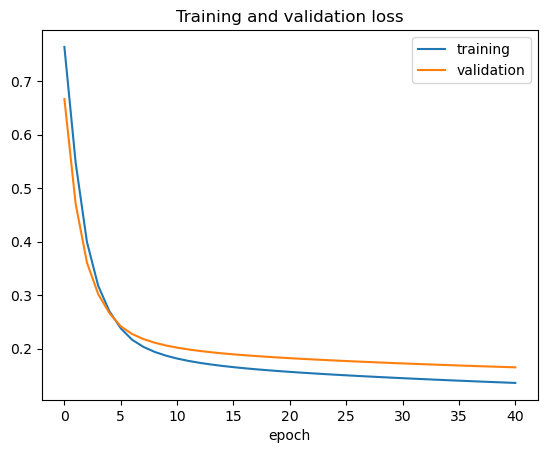

<Figure size 640x480 with 0 Axes>

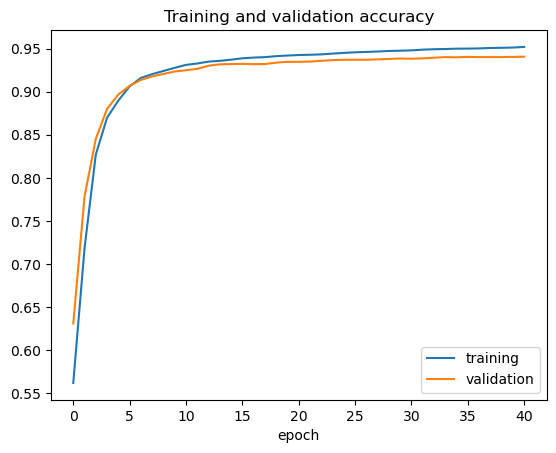

------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [18]:
# Call the function to print the summary of the model's performance during training
model_summary(model, history)

> **Figures Interpretation:**

* Training and Validation Loss: The first graph displays the loss on the y-axis and the number of epochs on the x-axis. Both training and validation loss start at a higher value and rapidly decrease, with the training loss continuing to decrease slightly and the validation loss plateauing as epochs increase. The fact that both lines converge and plateau without the validation loss increasing suggests that the model is learning effectively without overfitting to the training data.

* Training and Validation Accuracy: The second graph shows the accuracy metric over the same number of epochs. Both training and validation accuracy increase sharply in the initial epochs and then level off. The training accuracy reaches near 100%, while the validation accuracy is slightly lower but remains close to the training accuracy. This pattern indicates that the model generalizes well to unseen data. There's a high degree of accuracy without a significant gap between training and validation, which is a positive sign of the model's performance.

Together, these graphs provide a visual summary of the model's learning dynamics and confirm that the model is training as expected: learning from the data and generalizing to the validation set effectively. The "Best Epochs" noted at the top suggests that the model's best performance on the validation set was at epoch 41, which is likely where the weights were saved for future use. The corresponding training and test accuracy and loss values provide additional context on how the model performed quantitatively at that point.

# **Evaluation on test set**

After training, the ultimate test of our model's performance comes from its ability to predict unseen data. In this phase, we evaluate the model on the test set, which simulates how it would perform in real-world scenarios. This step is crucial as it provides an objective measure of the model's predictive power. We use the model's .predict() method to generate predictions for each instance in the test set. These predictions are then binarized (i.e., converted to 0 or 1) based on a threshold to classify each instance as 'Violence' or 'NonViolence'.

In [19]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 317ms/step


> Correct Predictions: 3952
> Wrong Predictions: 242


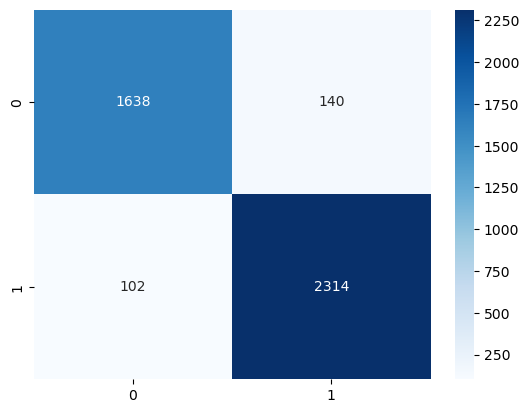

              precision    recall  f1-score   support

 NonViolence       0.94      0.92      0.93      1778
    Violence       0.94      0.96      0.95      2416

    accuracy                           0.94      4194
   macro avg       0.94      0.94      0.94      4194
weighted avg       0.94      0.94      0.94      4194



In [22]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix

# Generate a confusion matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

# Calculate the number of correct and wrong predictions
n_correct = int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

# Plot the confusion matrix using Seaborn for a better visual representation
sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

# displaying a detailed classification report
print(metrics.classification_report(y_test, preds,
                           target_names=["NonViolence", "Violence"]))

> **Resulsts Interpretation : EVALUATION**

>**Confusion Matrix**:
* The confusion matrix is a 2x2 grid that shows the number of correct and incorrect predictions made by the model.
* 1638 instances were correctly predicted as 'NonViolence' (True Negatives).
* 2314 instances were correctly predicted as 'Violence' (True Positives).
* 140 instances were incorrectly labeled as 'Violence' when they were actually 'NonViolence' (False Positives).
* 102 instances were incorrectly labeled as 'NonViolence' when they were actually 'Violence' (False Negatives).
* The model made a total of 3952 correct predictions and 242 wrong predictions.

>**Classification report**
* Precision : 0.94 , the model is highly precise.
* Recall :   'NonViolence' has a recall of 0.92, and 'Violence' has a recall of 0.96, which means the model is better at correctly identifying 'Violence'.
* F1 Score :  The F1-score is very high for both classes (0.93 for 'NonViolence' and 0.95 for 'Violence'), which is indicative of a well-performing model.
* Accuracy: The overall accuracy of the model on the test set is 0.94, which means it correctly predicts the label 94% of the time.

In [23]:
# Setting the name of the file where the trained model will be saved
args_model = "modelnew.h5"
# Save the entire model as a HDF5 file which is a portable format for storing complex data
model.save(args_model)

# Real-World Application: Video Violence Inference Doployment

Having trained and validated our model, we are now poised to deploy it in a real-world scenario to infer violence from video data. This involves loading the pre-trained model and using it to predict on new video samples that the model has not seen before, known as external or out-of-sample data. The process is as follows:

1. Load the Model: We first load the saved model which contains the learned weights.
2. Video Processing: Each video file is processed frame by frame to extract features similar to how we trained the model.
3. Prediction: The model then predicts each frame's likelihood of depicting violence.
4. Decision Making: By averaging the predictions across all frames, we determine the video's overall classification, setting a threshold for what constitutes violence.  
   
Through this process, we aim to classify videos into 'Violent' or 'Non-violent' categories, extending our model's application beyond the confines of the training dataset and into potential practical use cases.

In [10]:
# Load the model
from tensorflow.keras.models import load_model

args_model = load_model("modelnew.h5")

import math

# Function to preprocess a video and make predictions
def predict_violence(video_path):
    # Extract frames from the video
    frames = video_to_frames(video_path)
    # Preprocess each frame
    preprocessed_frames = [preprocess_frame(frame) for frame in frames]
    # Convert preprocessed frames to a numpy array
    input_data = np.array(preprocessed_frames)
    # Make predictions using the loaded model
    predictions = args_model.predict(input_data)
    # Calculate the average prediction score
    avg_prediction = np.mean(predictions)
    # Define a threshold for classifying the video as violent
    threshold = 0.5  # You can adjust this threshold as needed
    # Determine if the video is violent or not based on the average prediction score
    if avg_prediction >= threshold:
        return "Violent"
    else:
        return "Non-violent"

# Path to the video file
video_path = "Asma-vs-pablo.mp4"
# Make predictions on the video
video_classification = predict_violence(video_path)
print("Video classification:", video_classification)


ValueError: math domain error

# **API INTEGRATION**

To make our violence detection model operational in real-world applications, we've set up an API endpoint that allows for real-time video analysis. This API, defined in api.py, serves as an interface between the model and the end-user, facilitating the sending of video data for prediction and the receiving of the model's inference results.

>how the integrations works ?

1. **API Endpoint**: Our model is hosted on a local server accessible at the endpoint http://127.0.0.1:5000/predict. This server listens for incoming prediction requests.

2. **Sending Requests**: To communicate with the API, we use Postman, an API client that allows us to send requests to our server. In Postman, we set up a POST request to our endpoint.

3. **Request Body**: The request body contains a JSON object with the key "path" pointing to the local path of the video file we want to analyze, like so:  
   { 
    "path": "C:\\Users\\asmag\\Downloads\\Video-violence-detection-master\\test dataset\\POV-Fight-scene.mp4"
}

4. **Getting Predictions**: Upon sending the request, our API processes the video, leveraging our trained model to predict whether the content depicts violence. The result is then sent back as a JSON response, which, in this case, indicates if the video is "Violent" or "Non-violent".  

This API integration paves the way for seamless and scalable application of the violence detection model, as it can be easily called upon by various front-end services or applications that require video content moderation.


1st photo showing the POSTMAN interface  

2nd photo showing the output 

3rd photo showing the result on react js web interface

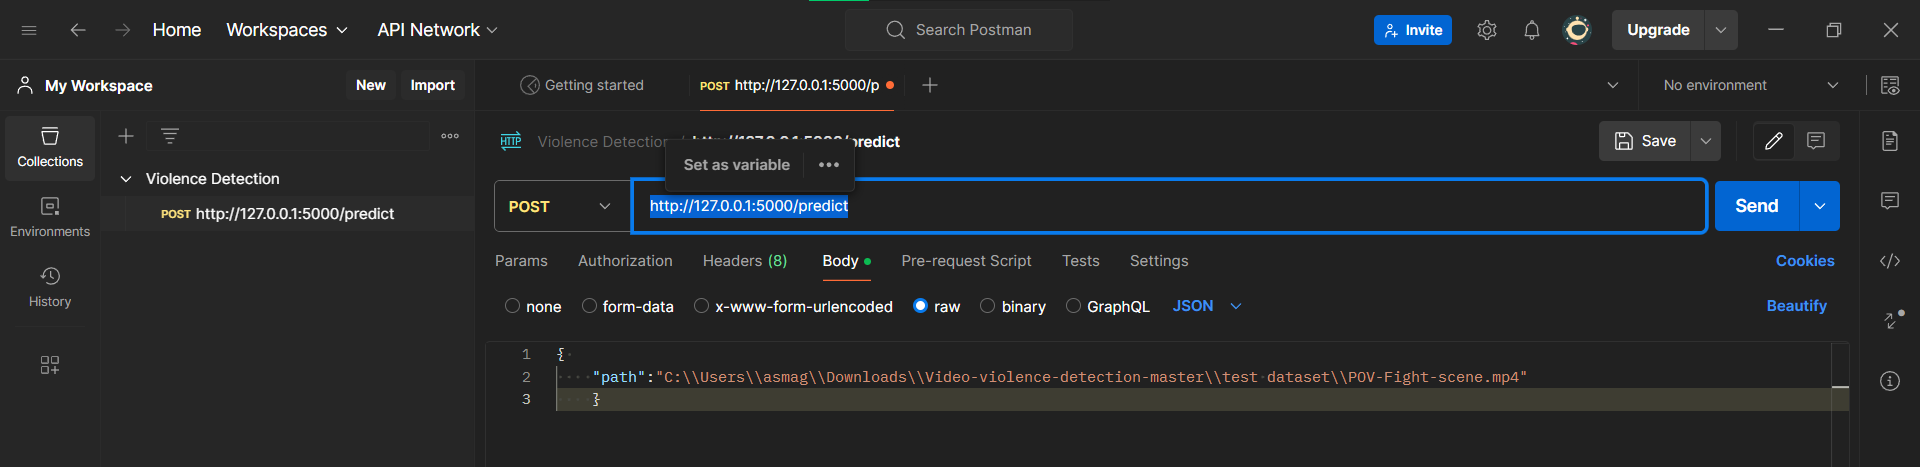

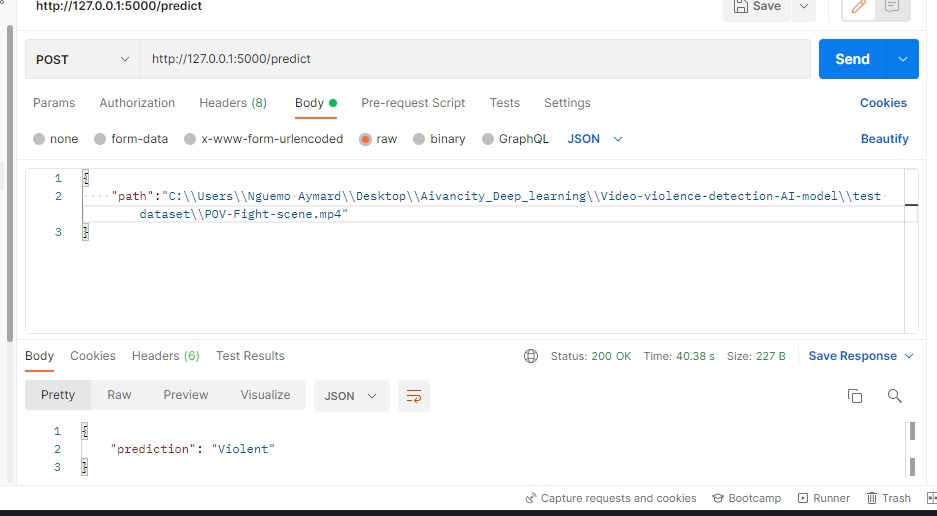

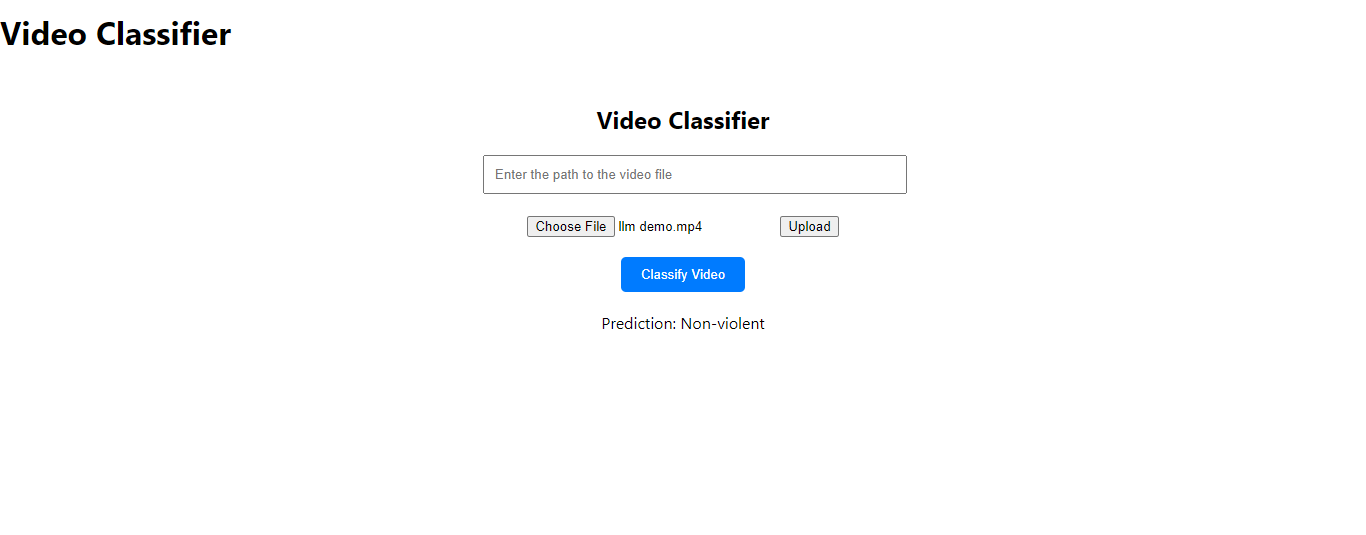

>This is all , thank you verry much ^^
From Asma & Aymard